# <center>Data Pre-Processing (Sample)</center>

## 0. Importing Libraries

In [186]:
!python --version

import warnings
warnings.filterwarnings('ignore')

Python 3.6.10 :: Anaconda, Inc.


In [2]:
import cv2     
import math   
import matplotlib.pyplot as plt    
import pandas as pd
import numpy as np 
from os import path
from os import listdir
from os.path import exists
from PIL import Image as img

%matplotlib inline

Unable to revert mtime: /Library/Fonts


## 1. Loading and combining play datasets

In [3]:
videos_csv = pd.read_csv('../data/play_data/Video.csv',sep=';')
plays_csv = pd.read_csv('../data/play_data/Play.csv',sep=';')
training_labels = pd.merge(plays_csv.iloc[:,[0,1,2,3,4,5,9,10]], videos_csv[['VideoFileName','VideoPath','PlayID','GameID']],left_on='ID', right_on='PlayID')
training_labels = training_labels[training_labels.Type.isin(['K', 'R', 'P', 'X', 'F', 'U'])]
cols = training_labels.columns
training_labels = training_labels.groupby(['Quarter','VideoFileName','GameID']).last().reset_index()
training_labels = training_labels[cols]
training_labels = training_labels[~training_labels['VideoPath'].str.startswith('2017')]
training_labels = training_labels.sample(n=len(training_labels), random_state=15)
training_labels.head()

ID  Down  ToGo Spot  \
5676  13548   2.0     5  H44   
327    6447   2.0     0  H04   
1349  11175   1.0     0  H35   
5930   3463   2.0     5  H10   
1767  12015   2.0     6  H43   

                                                   Text  Quarter HasBall Type  \
5676  2nd & 5 at GT44: TaQuon Marshall rush for 3 ya...        4       H    R   
327   2nd & GOAL at GT04: Bernard, G rush for 4 yard...        1       V    R   
1349  1st & GOAL at GT35: Butker, H. kickoff 65 yard...        1       H    K   
5930  2nd & 5 at GT10: Verica,M pass incomplete to B...        4       V    P   
1767  2nd & 6 at GT43: Marshall, M. rush for 1 yard ...        2       H    R   

     VideoFileName       VideoPath  PlayID  GameID  
5676           028  2016/G6009/Q4/   13548    6009  
327            009   2011/G781/Q1/    6447     781  
1349           043  2015/G5998/Q1/   11175    5998  
5930           037   2010/G340/Q4/    3463     340  
1767           009  2015/G6002/Q2/   12015    6002

In [199]:
training_labels_grayscale = training_labels.copy()

## 2 Splitting videos into static frames

In [3]:
total_plays = 800

sample_dist = {
    'R': int(0.34 * total_plays),
    'P': int(0.30 * total_plays),
    'K': int(0.12 * total_plays),
    'U': int(0.12 * total_plays),
    'X': int(0.06 * total_plays),
    'F': int(0.06 * total_plays)
}

current_counts = {
    'R': 0,
    'P': 0,
    'K': 0,
    'U': 0,
    'X': 0,
    'F': 0
}

unique_plays = set()

In [190]:
def extract_frames(row, label_dict, sample_dist, current_counts, unique_plays, fps=10, mode='rgb', total_plays=800):
    
    if np.sum(list(current_counts.values())) >= total_plays:
        return row
    
    play = str(row[-1]) + "_" + str(row[5]) + "_" + row[8]
    
    if play in unique_plays:
        return row
        
    if current_counts[row['Type']] < sample_dist[row['Type']]:
        video_path = '../data/videos_high_resolution/' + row[9] + 'raw/' + row[8] + '.mp4'
        label = row[7]
        if path.exists(video_path):
            cap = cv2.VideoCapture(video_path)
            frameRate = cap.get(cv2.CAP_PROP_FPS)
            x = 1
            count = 0
            write_worked = False
            while(cap.isOpened()):
                frameId = cap.get(cv2.CAP_PROP_POS_FRAMES)
                ret, frame = cap.read()
                if (ret != True):
                    break
                if ((frameId % (math.ceil(frameRate) // fps)) == 0):
                    filename = "../data/stadium-iopt/sub_sample/training_frames/" + mode + "/" + str(row[-1]) + "_" + str(row[5]) + "_" + row[8] + "_" + "frame%d.jpg" % count
                    count+=1
                    h, w, c = frame.shape
                    y = (w-h)//2
                    good = frame[:, y:y+h]
                    good = cv2.resize(good,(224,224))
                    if mode == 'grayscale':
                        good = cv2.cvtColor(good,cv2.COLOR_BGR2GRAY)
                    if cv2.imwrite(filename, good):
                        label_dict[filename] = [play, count, label]
                        write_worked = True
            cap.release()
            if write_worked:
                unique_plays.add(play)
                current_counts[row['Type']] += 1
    return row

In [191]:
label_dict = {}
mode = 'rgb'
rgb_dir = "../data/stadium-iopt/sub_sample/training_frames/" + mode

file_count = len([name for name in listdir(rgb_dir) if not name.startswith(".")])

if file_count == 0:
    training_labels.apply(lambda row: extract_frames(row,
                                                     label_dict,
                                                     sample_dist,
                                                     current_counts,
                                                     unique_plays,
                                                     10,
                                                     'rgb'), axis=1)

In [192]:
total_plays = 800

sample_dist = {
    'R': 0.34 * total_plays,
    'P': 0.30 * total_plays,
    'K': 0.12 * total_plays,
    'U': 0.12 * total_plays,
    'X': 0.06 * total_plays,
    'F': 0.06 * total_plays
}

current_counts = {
    'R': 0,
    'P': 0,
    'K': 0,
    'U': 0,
    'X': 0,
    'F': 0
}

unique_plays = set()

In [201]:
label_dict_grayscale = {}
mode = 'grayscale'
grayscale_dir = "../data/stadium-iopt/sub_sample/training_frames/" + mode

file_count = len([name for name in listdir(grayscale_dir) if not name.startswith(".")])

if file_count == 0:
    training_labels_grayscale.apply(lambda row: extract_frames(row,
                                                               label_dict_grayscale,
                                                               sample_dist, 
                                                               current_counts,
                                                               unique_plays,
                                                               10,
                                                               'grayscale'), axis=1)

## 3. Saving the training frames' labels

In [194]:
label_map = {
    'K': 0,
    'R': 1,
    'P': 2,
    'X': 3,
    'F': 4,
    'U': 5,
}

In [45]:
mode = 'rgb'

file_path = "../data/stadium-iopt/sub_sample/training_labels/" + mode + "/" + "labels.csv"

if not exists(file_path):
    labels_df = pd.DataFrame.from_dict(label_dict, orient='index').reset_index()
    labels_df.columns = ['filename','play','frame','label']
    labels_df['filename'] = labels_df['filename'].apply(lambda x: x.split('/')[-1])
    labels_df['numeric_label'] = labels_df['label'].map(label_map)
    labels_df.to_csv(file_path, index=False)
else:
    labels_df = pd.read_csv(file_path)
labels_df.head()

filename        play  frame label  numeric_label
0  6009_4_028_frame0.jpg  6009_4_028      1     R              1
1  6009_4_028_frame1.jpg  6009_4_028      2     R              1
2  6009_4_028_frame2.jpg  6009_4_028      3     R              1
3  6009_4_028_frame3.jpg  6009_4_028      4     R              1
4  6009_4_028_frame4.jpg  6009_4_028      5     R              1

In [5]:
display(sample_dist)
labels_df.groupby('play').last().groupby('label').count()

{'R': 272, 'P': 240, 'K': 96, 'U': 96, 'X': 48, 'F': 48}

filename  frame  numeric_label
label                                
F            48     48             48
K            96     96             96
P           240    240            240
R           272    272            272
U            96     96             96
X            48     48             48

In [55]:
mode = 'grayscale'


file_path = "../data/stadium-iopt/sub_sample/training_labels/" + mode + "/" + "labels.csv"

if not exists(file_path):
    labels_df_grayscale = pd.DataFrame.from_dict(label_dict_grayscale, orient='index').reset_index()
    labels_df_grayscale.columns = ['filename','play','frame','label']
    labels_df_grayscale['filename'] = labels_df_grayscale['filename'].apply(lambda x: x.split('/')[-1])
    labels_df_grayscale['numeric_label'] = labels_df_grayscale['label'].map(label_map)
    labels_df_grayscale.to_csv(file_path, index=False)
else:
    labels_df_grayscale = pd.read_csv(file_path)
labels_df_grayscale.head()

filename        play  frame label  numeric_label
0  6009_4_028_frame0.jpg  6009_4_028      1     R              1
1  6009_4_028_frame1.jpg  6009_4_028      2     R              1
2  6009_4_028_frame2.jpg  6009_4_028      3     R              1
3  6009_4_028_frame3.jpg  6009_4_028      4     R              1
4  6009_4_028_frame4.jpg  6009_4_028      5     R              1

In [6]:
display(sample_dist)
labels_df.groupby('play').last().groupby('label').count()

{'R': 272, 'P': 240, 'K': 96, 'U': 96, 'X': 48, 'F': 48}

filename  frame  numeric_label
label                                
F            48     48             48
K            96     96             96
P           240    240            240
R           272    272            272
U            96     96             96
X            48     48             48

## 4. Creating a numpy array with all the frames for each play

In [204]:
mode = 'rgb'

path = "../data/stadium-iopt/sub_sample/training_frames/" + mode + "/"
images =  [[]]
prev_play = labels_df.play[0]
play_idx = 0
plays = [labels_df.iloc[0].play]
labels = [labels_df.iloc[0].numeric_label]
char_labels = [labels_df.iloc[0].label]

rgb_np_dir = "../data/stadium-iopt/sub_sample/numpy_data/" + mode + "/"
file_count = len([name for name in listdir(rgb_np_dir) if not name.startswith(".")])

if file_count == 0:
    for idx, row in labels_df.iterrows():
        image = img.open(path + row.filename)
        if prev_play != row.play:
            images[play_idx] = np.asarray(images[play_idx])
            play_idx += 1
            prev_play = row.play
            images.append([])
            labels.append(row.numeric_label)
            char_labels.append(row.label)
            plays.append(row.play)
            if ((play_idx % 1000) == 0) or ((play_idx == (2000 - 1))) or (play_idx == 1):
                print("Video " + str(play_idx) + " of " + str(total_plays))
        images[play_idx].append(np.asarray(image))

    images[-1] = np.asarray(images[-1])    
    images = np.asarray(images)

Video 1 of 2000


In [205]:
print(images.shape)
print(images[0].shape)
print(images[0][0].shape)

(800,)
(90, 224, 224, 3)
(224, 224, 3)


In [206]:
print(len(labels))
print(len(char_labels))
print(len(plays))

800
800
800


In [207]:
# Saving the numeric labels

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/numeric_labels.npy', labels)

# Saving the char labels

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/char_labels.npy', char_labels)

# Saving the play numbers

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/plays.npy', plays)

In [209]:
# Saving the numpy array containing all the frames for each play

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/images.npy', images)

In [212]:
mode = 'grayscale'

path = "../data/stadium-iopt/sub_sample/training_frames/" + mode + "/"
images_grayscale =  [[]]
prev_play = labels_df_grayscale.play[0]
play_idx = 0
plays_grayscale = [labels_df_grayscale.iloc[0].play]
labels_grayscale = [labels_df_grayscale.iloc[0].numeric_label]
char_labels_grayscale = [labels_df_grayscale.iloc[0].label]

grayscale_np_dir = "../data/stadium-iopt/sub_sample/numpy_data/" + mode + "/"
file_count = len([name for name in listdir(grayscale_np_dir) if not name.startswith(".")])

if file_count == 0:
    for idx, row in labels_df_grayscale.iterrows():
        image = img.open(path + row.filename)
        if prev_play != row.play:
            images_grayscale[play_idx] = np.asarray(images_grayscale[play_idx])
            play_idx += 1
            prev_play = row.play
            images_grayscale.append([])
            labels_grayscale.append(row.numeric_label)
            char_labels_grayscale.append(row.label)
            plays_grayscale.append(row.play)
            if play_idx % 1000 == 0 or play_idx == (2000 - 1) or (play_idx == 1):
                print("Video " + str(play_idx + 1) + " of " + str(total_plays))
        images_grayscale[play_idx].append(np.asarray(image))

    images_grayscale[-1] = np.asarray(images_grayscale[-1])    
    images_grayscale = np.asarray(images_grayscale)

Video 2 of 2000


In [37]:
display(sample_dist)
labels_df.groupby('play').last().groupby('label').count()

{'R': 272, 'P': 240, 'K': 96, 'U': 96, 'X': 48, 'F': 48}

filename  frame  numeric_label
label                                
F            48     48             48
K            96     96             96
P           240    240            240
R           272    272            272
U            96     96             96
X            48     48             48

In [216]:
print(images_grayscale.shape)
print(images_grayscale[0].shape)
print(images_grayscale[0][0].shape)

(800,)
(90, 224, 224)
(224, 224)


In [217]:
print(len(labels_grayscale))
print(len(char_labels_grayscale))
print(len(plays_grayscale))

800
800
800


In [218]:
# Saving the numeric labels_grayscale

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/numeric_labels_grayscale.npy', labels_grayscale)

# Saving the char labels_grayscale

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/char_labels_grayscale.npy', char_labels_grayscale)

# Saving the play numbers

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/plays_grayscale.npy', plays_grayscale)

In [219]:
# Saving the numpy array containing all the frames for each play

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/images_grayscale.npy', images_grayscale)

## 5. Converting the training labels to one-hot vectors

In [47]:
one_hot_labels = np.zeros((len(labels),len(labels_df.numeric_label.unique())))
idx = 0

for label in labels:
    one_hot_labels[idx][label] = 1
    idx += 1
    
one_hot_labels = np.asarray(one_hot_labels)

In [48]:
mode = 'rgb'

# Saving the numpy array containing all the labels as one-hot encoded vectors

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/one_hot_labels.npy', one_hot_labels)

In [56]:
one_hot_labels_grayscale = np.zeros((len(labels_grayscale),len(labels_df_grayscale.numeric_label.unique())))
idx = 0

for label in labels_grayscale:
    one_hot_labels_grayscale[idx][label] = 1
    idx += 1
    
one_hot_labels_grayscale = np.asarray(one_hot_labels_grayscale)

In [57]:
mode = 'grayscale'

# Saving the numpy array containing all the labels as one-hot encoded vectors

np.save('../data/stadium-iopt/sub_sample/numpy_data/' + mode + '/one_hot_labels_grayscale.npy', one_hot_labels_grayscale)

## 6. Plotting all the training frames for a play

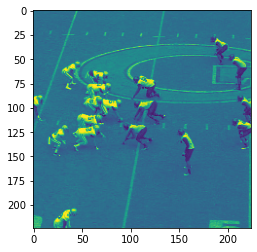

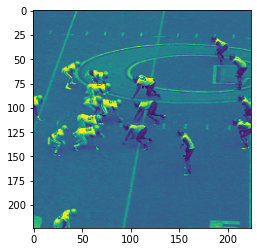

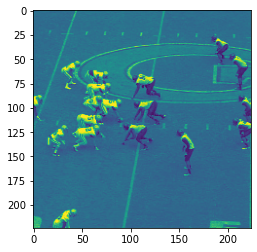

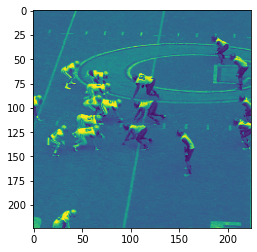

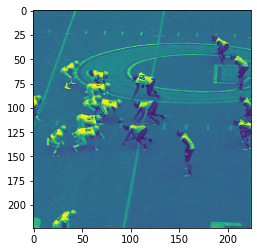

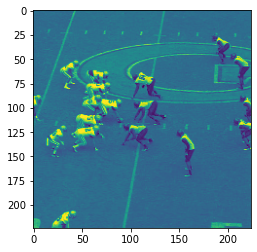

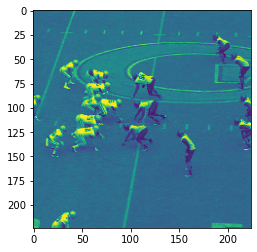

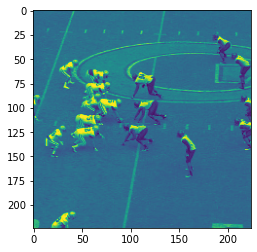

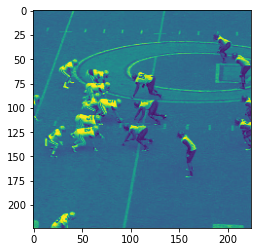

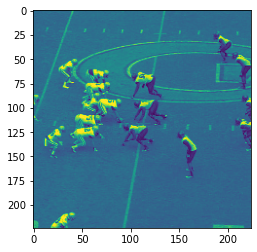

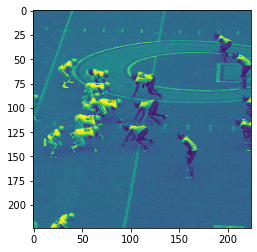

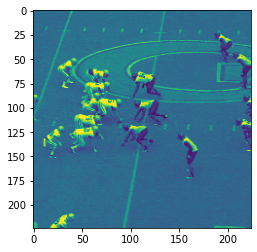

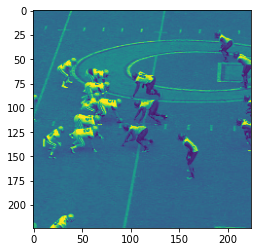

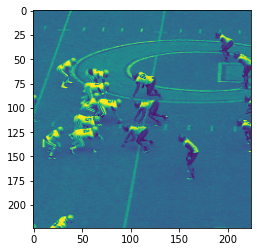

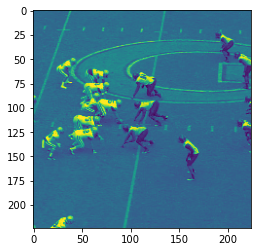

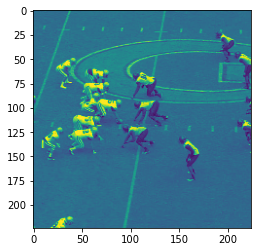

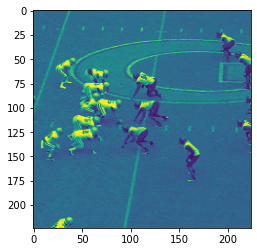

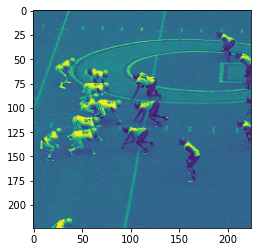

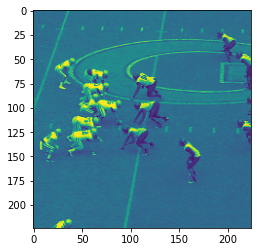

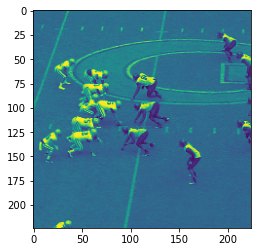

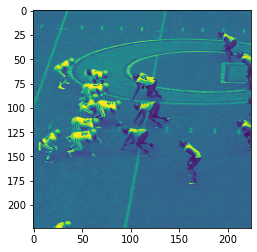

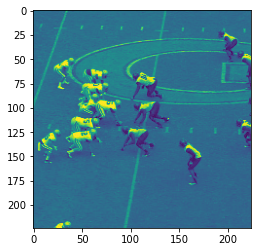

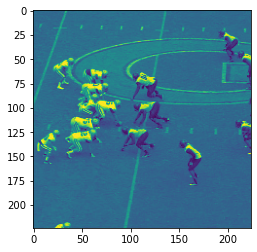

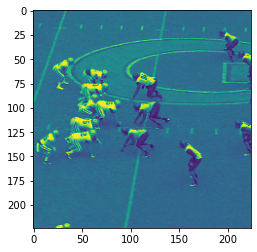

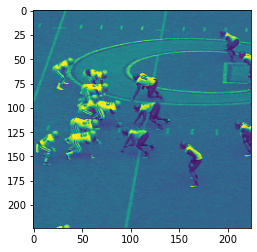

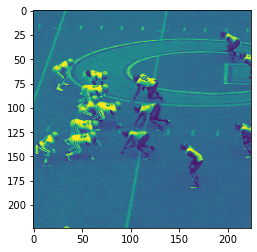

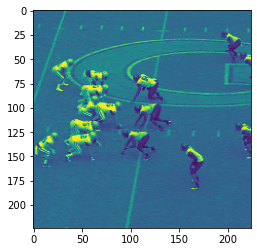

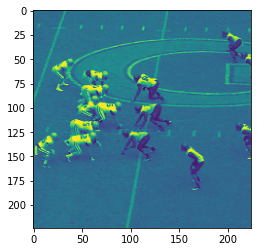

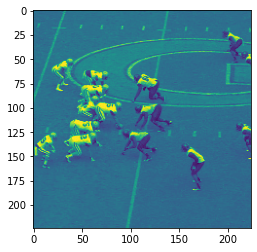

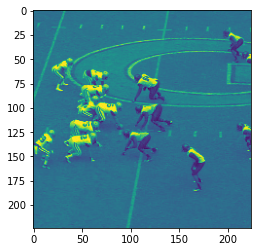

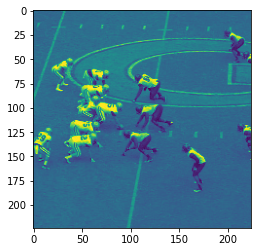

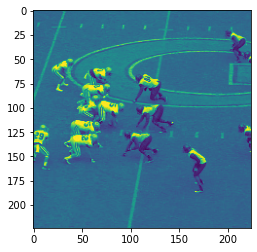

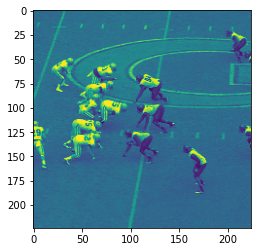

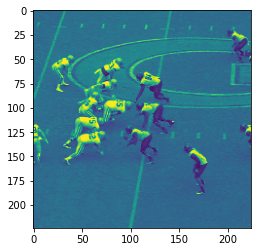

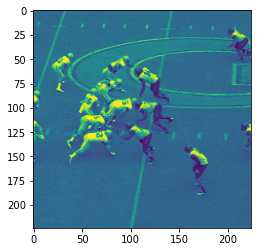

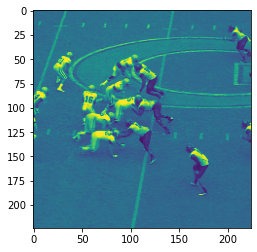

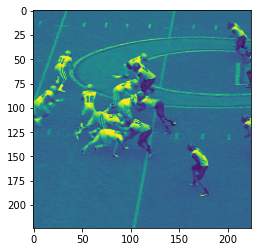

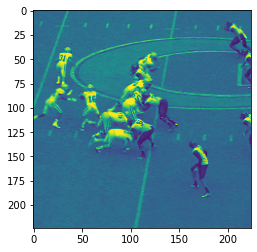

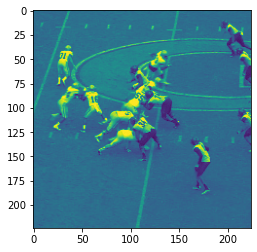

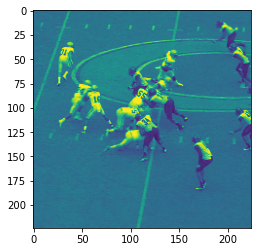

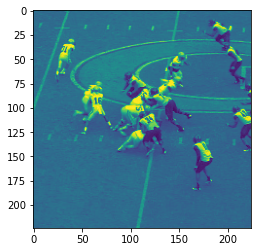

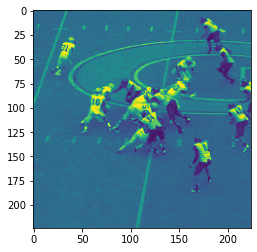

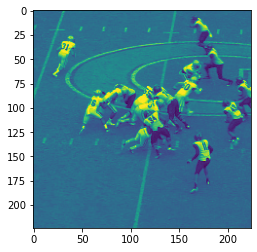

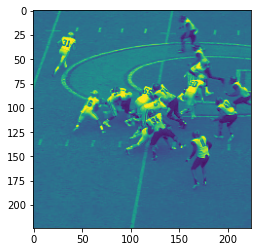

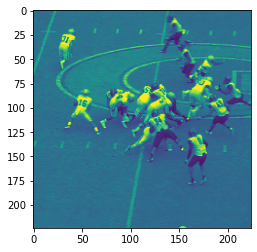

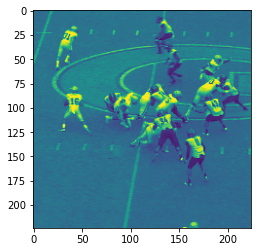

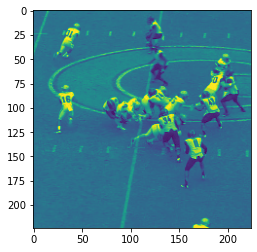

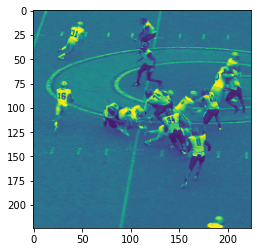

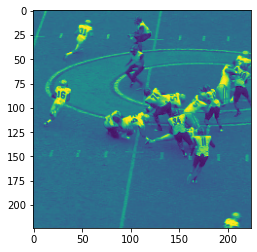

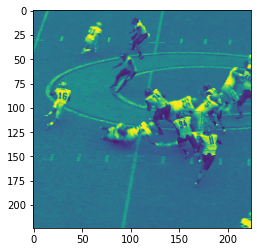

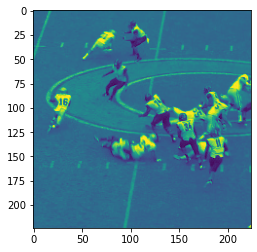

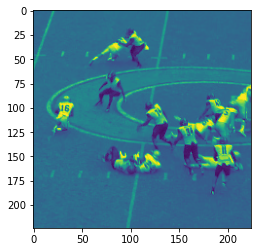

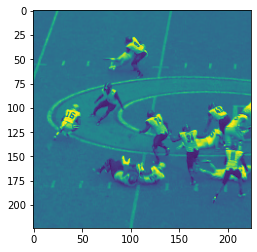

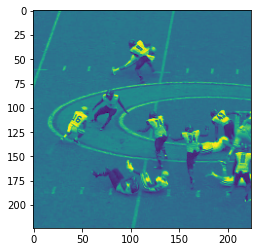

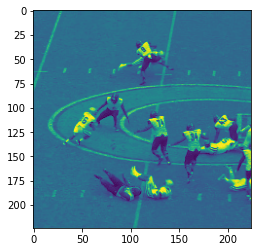

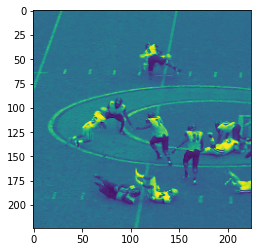

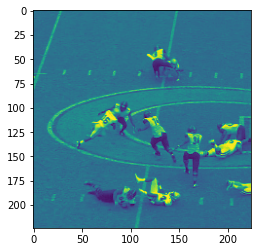

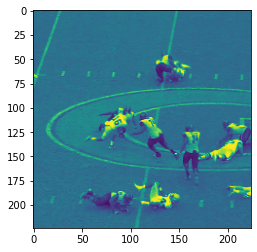

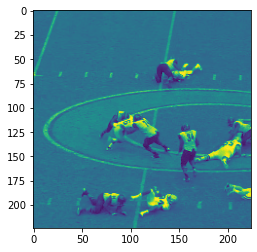

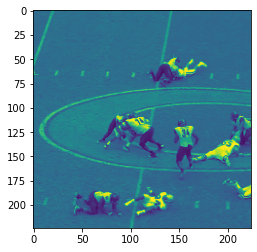

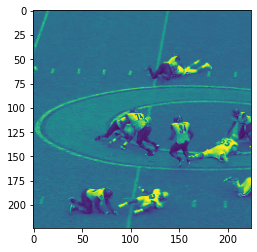

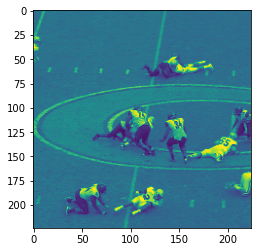

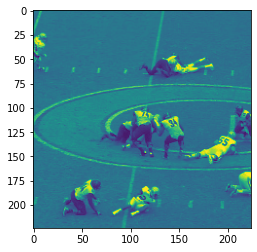

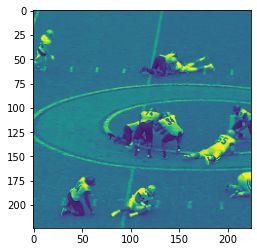

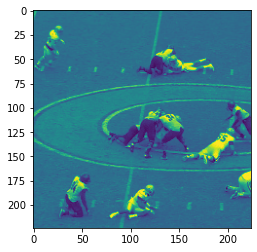

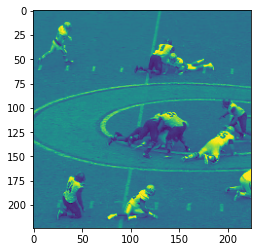

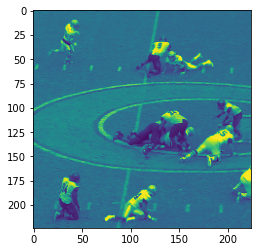

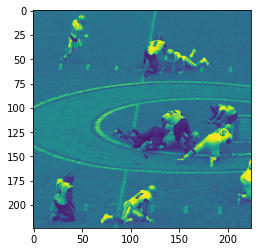

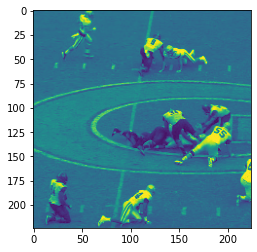

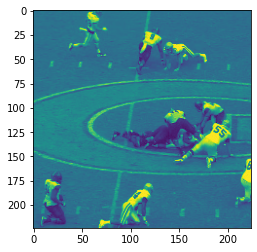

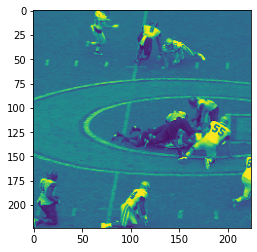

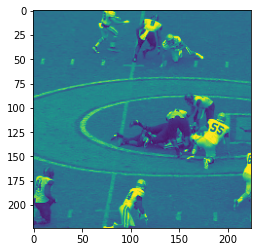

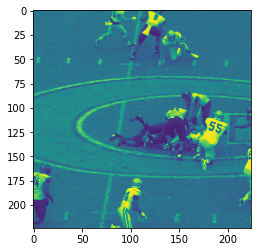

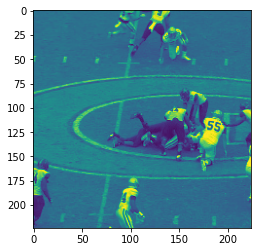

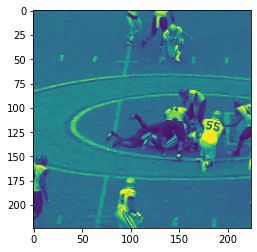

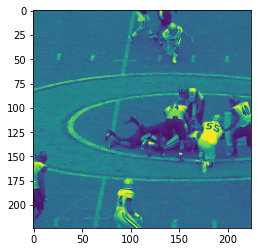

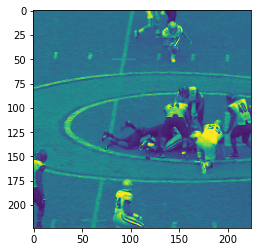

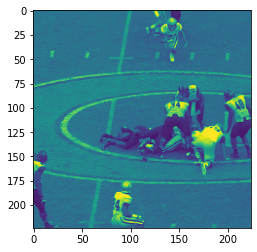

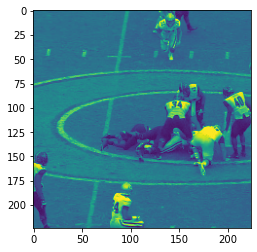

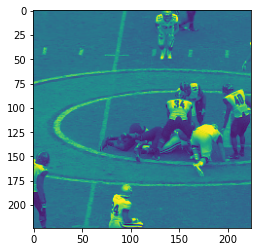

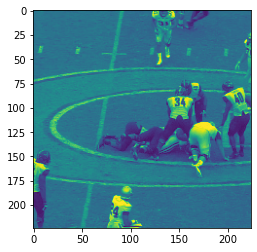

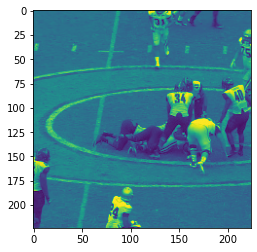

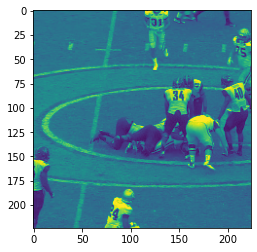

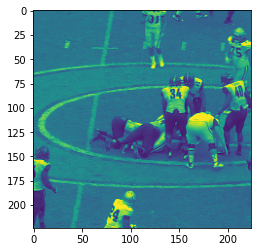

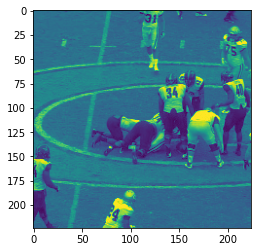

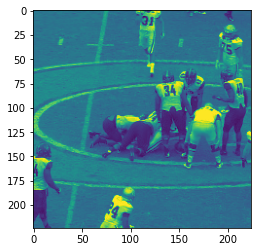

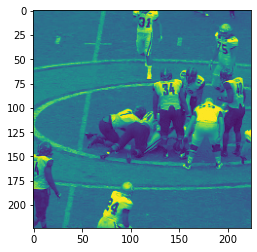

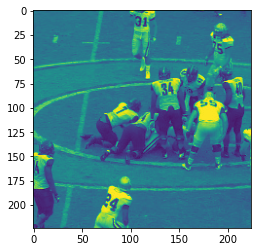

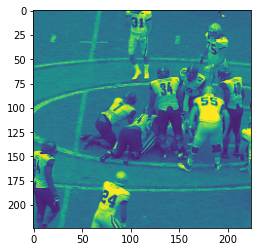

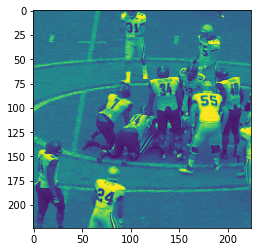

In [225]:
for i in range(len(images_grayscale[0])):
    plt.figure()
    plt.imshow(images_grayscale[0][i])